# Requirements

In [110]:
import pandas as pd
import numpy as np
import requests
import re
import json
import random
import scipy
import nltk

import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
#import proplot as plot
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
import seaborn as sns
#import geoplot as gplt
import warnings
warnings.filterwarnings('ignore')

import sddk
import tempun

In [4]:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [5]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

# Import the dataset

In [6]:
# read local version:
LIREg = gpd.read_file("../data/large_data/LIREg_occupsorgs.geojson", driver="GeoJSON")
# or use the version from sciencedata
#LIREg = s.read_file("SDAM_data/social_diversity/LIRE_occupsorgs_2021-08-31.geojson", "gdf")
LIREg.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,occups,occups_N,organizations,organizations_N,curator,geometry
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,minor,0.097513,honorific inscription,1.0,[],0,[],0,[],POINT (20.76680 39.45120)
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,big,0.004249,mile-/leaguestone,1.0,[],0,[],0,[],POINT (22.41710 37.43190)
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,big,0.004249,public legal inscription,1.0,[],0,[],0,[],POINT (22.41710 37.43190)
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,minor,0.520308,votive inscription,1.0,[],0,[],0,[],POINT (24.83230 37.81880)
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{},{},...,minor,0.262624,owner/artist inscription,1.0,[],0,[],0,[],POINT (21.62710 37.64790)


In [122]:
def try_eval(cell_value):
    try: return eval(cell_value)
    except: return cell_value
for col in LIREg.columns:
    LIREg[col] = LIREg[col].apply(try_eval)

# Random dates and overall simulations

In [23]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
LIREg["random_dates"] = LIREg.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000, seed=row.name), axis=1)

CPU times: user 1min 11s, sys: 1.42 s, total: 1min 13s
Wall time: 1min 13s


In [24]:
LIREg.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,occups,occups_N,organizations,organizations_N,curator,geometry,random_dates
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,0.097513,honorific inscription,1.0,[],0,[],0,[],POINT (20.76680 39.45120),"[311, 312, 311, 311, 311, 312, 311, 313, 313, ..."
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,0.004249,mile-/leaguestone,1.0,[],0,[],0,[],POINT (22.41710 37.43190),"[276, 276, 276, 276, 276, 276, 276, 276, 276, ..."
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,0.004249,public legal inscription,1.0,[],0,[],0,[],POINT (22.41710 37.43190),"[49, 49, 50, 49, 49, 49, 49, 50, 49, 49, 50, 5..."
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,0.520308,votive inscription,1.0,[],0,[],0,[],POINT (24.83230 37.81880),"[204, 206, 201, 204, 208, 208, 199, 200, 199, ..."
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{},{},...,0.262624,owner/artist inscription,1.0,[],0,[],0,[],POINT (21.62710 37.64790),"[96, 89, 96, 92, 91, 84, 96, 81, 85, 88, 93, 8..."


In [25]:
%%time
LIRE_complete_simulations = tempun.timeblocks_from_randoms(LIREg, "random_dates", [-50, 350, 50])

CPU times: user 7.44 s, sys: 52 ms, total: 7.49 s
Wall time: 7.49 s


In [26]:
LIRE_complete_simulations[0]

[((-50, -1), 5360),
 ((1, 50), 20298),
 ((51, 100), 20207),
 ((101, 150), 22343),
 ((151, 200), 22261),
 ((201, 250), 18314),
 ((251, 300), 9584),
 ((301, 350), 7944)]

In [27]:
LIRE_complete_merged = tempun.simulations_merged(LIRE_complete_simulations)

In [28]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Julio-Claudian" : {"startdate": -27, "enddate" : 68},
    "Flavian" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 192},
    "Severan" : {"startdate": 193, "enddate": 235},
    "Barracks emperors" : {"startdate" : 236, "enddate" : 284},
    "Tetrarchy\n& Constantine I" : {"startdate" : 285, "enddate" : 337}
    }
timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-27, 68), (69, 96), (97, 192), (193, 235), (236, 284), (285, 337)]

# Occupations and organizations over time

In [29]:
var_data_occups, var_data_orgs = [], []
for var_n in range(1000):
    var_data_occups.append([var[var_n] for var in LIREg[LIREg["occups_N"] > 0]["random_dates"] if var !=None])
    var_data_orgs.append([var[var_n] for var in LIREg[LIREg["organizations_N"] > 0]["random_dates"] if var !=None])

In [30]:
print(len(var_data_occups[0]))
print(len(var_data_orgs[0]))

4088
1242


In [37]:
%%time
var_data_lire = []
for var_n in range(1000):
    var_data_lire.append([var[var_n] for var in LIREg["random_dates"] if var !=None])

CPU times: user 52.4 s, sys: 328 ms, total: 52.8 s
Wall time: 52.8 s


In [54]:
sample_size = len(var_data_occups[0]) # + len(var_data_orgs[0])
sample_size

4088

In [55]:
colors_list = [color for color in list(mcolors.CSS4_COLORS.keys()) if "light" in color][2:]
colors_list

['lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 'lightgreen',
 'lightgrey',
 'lightpink',
 'lightsalmon',
 'lightseagreen',
 'lightskyblue',
 'lightslategray',
 'lightslategrey',
 'lightsteelblue',
 'lightyellow']

CPU times: user 5.5 s, sys: 64.7 ms, total: 5.56 s
Wall time: 5.4 s


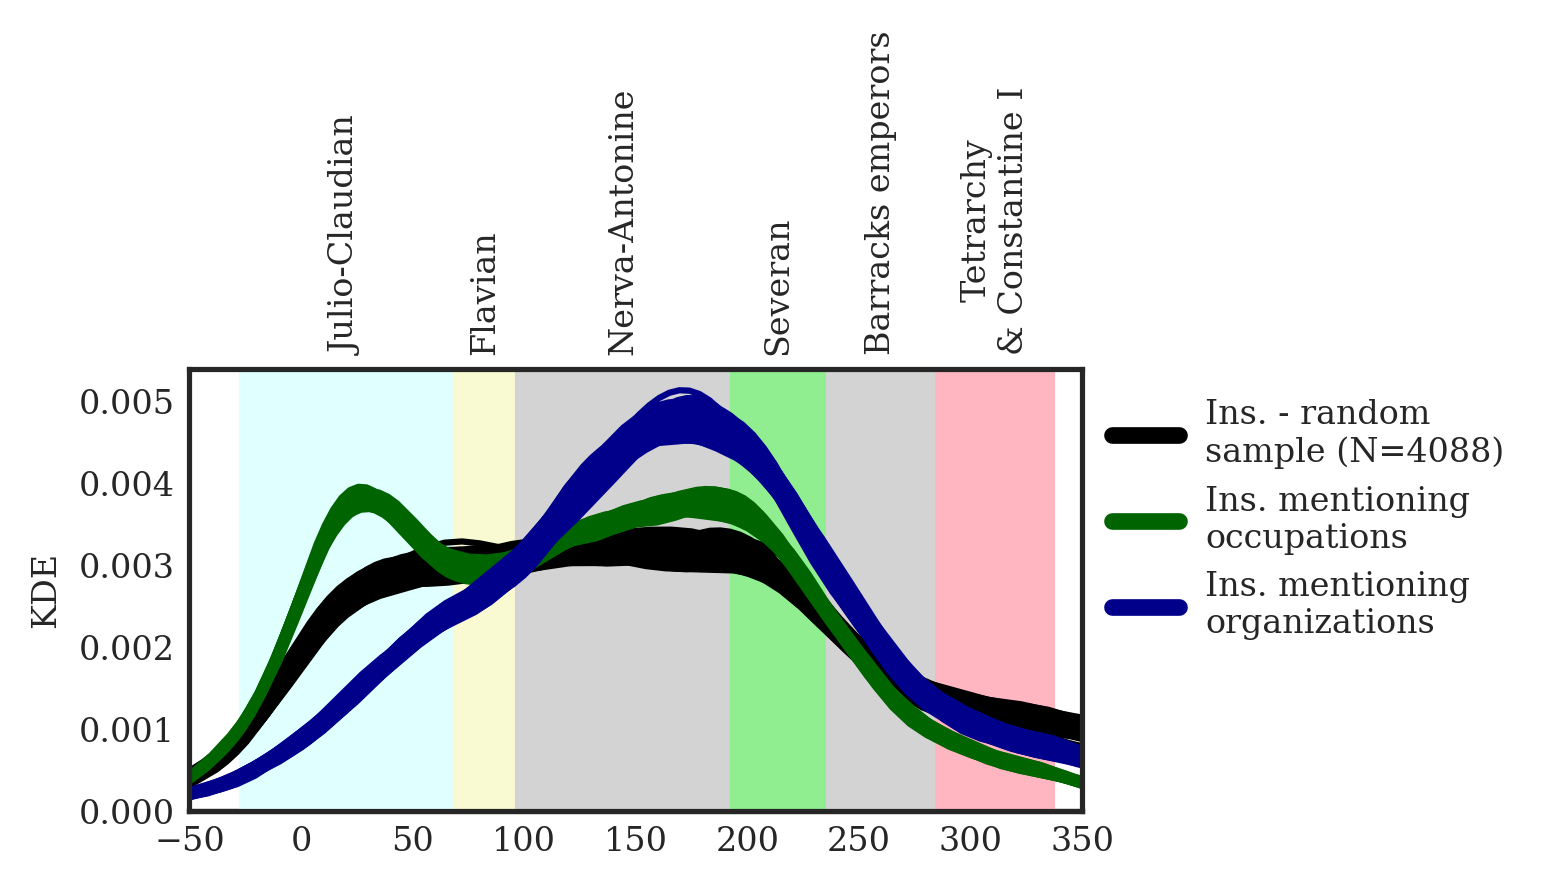

In [57]:
%%time 
# timeconsuming, because of the KDE involved

labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

#positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, ax = plt.subplots(figsize=[5.2, 3], tight_layout=True)

for period, color in zip(periods.keys(), colors_list):
    ax.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")


for data in var_data_lire[:100]:
    # to be based on sample or not... 
    data = random.sample(data, k=sample_size)
    sns.kdeplot(data, ax=ax, color="black") #, alpha=0.5)   
    
for data in var_data_occups[:100]:
    sns.kdeplot(data, ax=ax, color="darkgreen") #, alpha=0.5)
    
for data in var_data_orgs[:100]:
    sns.kdeplot(data, ax=ax, color="darkblue") # , alpha=0.5)
 

    
ax.set_xlim(-50,350)



ax.set_ylabel("KDE")

# period labels
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.tick_top()

# time ticks
ax.secondary_xaxis("bottom")


markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in ["black", "darkgreen", "darkblue"]]
plt.legend(markers, ["Ins. - random\nsample (N={0})".format(str(sample_size)), "Ins. mentioning\noccupations", "Ins. mentioning\norganizations"], bbox_to_anchor=(1, 1), loc='upper left')


In [58]:
#sddk.write_file(figpath + "comparing_distributions_kde.eps", fig, conf)
figpath = "SDAM_data/social_diversity/socdiv_figures/"
s.write_file(figpath +"comparing_distributions_kde.png", fig)
s.write_file(figpath + "comparing_distributions_kde.eps", fig)

A file with the same name ("comparing_distributions_kde.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/comparing_distributions_kde.png"
A file with the same name ("comparing_distributions_kde.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/comparing_distributions_kde.eps"


# Statistical comparison


We use two-sample Kolmogorov-Smirnov test, which checks whether  two data samples come from the same distribution. This does not specify what that common distribution is (e.g. whether it's normal or not normal).  

We employ it to compare distribution of all iscriptions mentioning an occupation/organization against a distribution based on a random sample of inscriptions of the same length. We repeat this procedure for all dating simulations and evaluate the consinstency of the findings.

In [59]:
# one variant example
scipy.stats.kstest(var_data_orgs[0], random.sample(var_data_lire[0], k=len(var_data_orgs[0])))

KstestResult(statistic=0.13365539452495975, pvalue=4.3696355683209083e-10)

In [60]:
random.seed(0)
p_values, KS_stats = [], []
for var_n in range(len(var_data_lire)):
    ks, p = scipy.stats.ks_2samp(var_data_orgs[var_n], random.sample(var_data_lire[var_n], k=len(var_data_orgs[var_n])))
    KS_stats.append(ks)
    p_values.append(p)
len([p for p in p_values if p < 0.001])

1000

In [61]:
random.seed(0)
p_values, KS_stats = [], []
for var_n in range(len(var_data_lire)):
    ks, p = scipy.stats.ks_2samp(var_data_occups[var_n], random.sample(var_data_lire[var_n], k=len(var_data_occups[var_n])))
    KS_stats.append(ks)
    p_values.append(p)
len([p for p in p_values if p < 0.001])

1000

# Occupations & organizations over inscription types

In [63]:
simulations_by_type_len = []

for ins_type in LIREg["type_of_inscription_auto"].unique():
    if ins_type != "NULL":
        subset_df = LIREg[LIREg["type_of_inscription_auto"]==ins_type]
        simulations_by_type_len.append((ins_type, len(subset_df)))
simulations_by_type_len = sorted(simulations_by_type_len, key = lambda x: x[1], reverse=True)
simulations_by_type_len

[('epitaph', 75124),
 ('votive inscription', 15851),
 ('owner/artist inscription', 10577),
 ('honorific inscription', 5600),
 ('building/dedicatory inscription', 3279),
 ('mile-/leaguestone', 2554),
 ('identification inscription', 1927),
 ('acclamation', 448),
 ('boundary inscription', 414),
 ('military diploma', 331),
 ('list', 297),
 ('defixio', 294),
 ('letter', 292),
 ('label', 289),
 ('elogium', 151),
 ('public legal inscription', 135),
 ('seat inscription', 55),
 ('private legal inscription', 38),
 ('prayer', 23),
 ('assignation inscription', 16),
 ('calendar', 14),
 ('adnuntiatio', 1),
 (None, 0)]

In [65]:
# N of occuptions and N of organization per inscription category
ins_types_occs_orgs = []
for ins_type_tup in simulations_by_type_len[:-1]:
    subset_df = LIREg[LIREg["type_of_inscription_clean"]==ins_type_tup[0]]
    occ_N = subset_df["occups_N"].sum()
    orgs_N = subset_df["organizations_N"].sum()
    ins_types_occs_orgs.append([ins_type_tup[0] + " (N={0})".format(len(subset_df)), occ_N, orgs_N])
    print("inscription type: {0}, N of occupations: {1}, N of organizations: {2}".format(ins_type_tup[0], str(occ_N), str(orgs_N)))

inscription type: epitaph, N of occupations: 619, N of organizations: 220
inscription type: votive inscription, N of occupations: 384, N of organizations: 142
inscription type: owner/artist inscription, N of occupations: 34, N of organizations: 0
inscription type: honorific inscription, N of occupations: 363, N of organizations: 82
inscription type: building/dedicatory inscription, N of occupations: 111, N of organizations: 53
inscription type: mile-/leaguestone, N of occupations: 0, N of organizations: 0
inscription type: identification inscription, N of occupations: 11, N of organizations: 0
inscription type: acclamation, N of occupations: 3, N of organizations: 0
inscription type: boundary inscription, N of occupations: 9, N of organizations: 3
inscription type: military diploma, N of occupations: 38, N of organizations: 0
inscription type: list, N of occupations: 42, N of organizations: 15
inscription type: defixio, N of occupations: 6, N of organizations: 2
inscription type: lette

In [66]:
pd.DataFrame(ins_types_occs_orgs, columns=["inscription type", "occupations", "organisations"])

,inscription type,occupations,organisations
0,epitaph (N=22902),619,220
1,votive inscription (N=12328),384,142
2,owner/artist inscription (N=3851),34,0
3,honorific inscription (N=3089),363,82
4,building/dedicatory inscription (N=2699),111,53
5,mile-/leaguestone (N=1413),0,0
6,identification inscription (N=1182),11,0
7,acclamation (N=364),3,0
8,boundary inscription (N=181),9,3
9,military diploma (N=214),38,0


In [70]:
def wordcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()

In [71]:
types, occups_freqs, orgs_freqs = [], [], [] 

for ins_type_tup in simulations_by_type_len[:10][::-1]: # for horizontal bar below, we need the list in reverse order, therefore: [::-1]
    subset_df = LIREg[LIREg["type_of_inscription_clean"]==ins_type_tup[0]]
    subset_wordcount = wordcount(subset_df).sum()
    types.append(ins_type_tup[0])
    occups_freqs.append(subset_df["occups_N"].sum() / subset_wordcount * 1000)
    orgs_freqs.append(subset_df["organizations_N"].sum() / subset_wordcount * 1000)

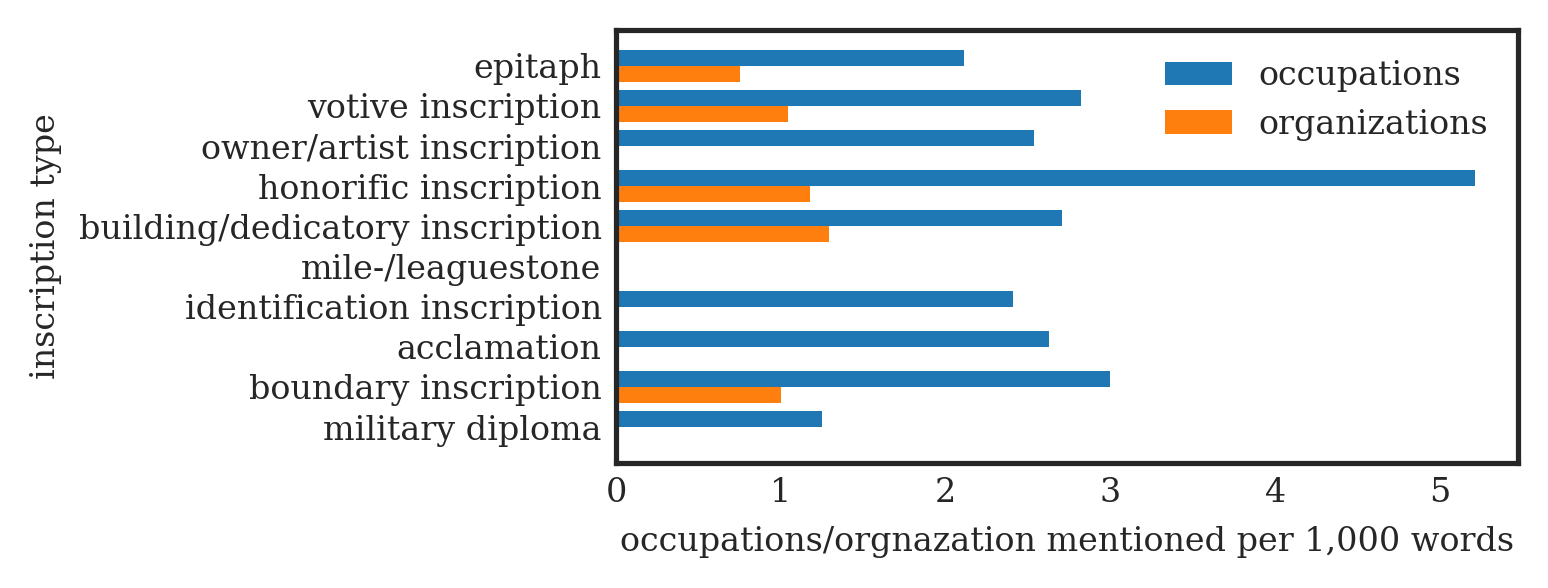

In [73]:
fig, ax  = plt.subplots(figsize=(5.2, 2), tight_layout=True)

y = np.arange(len(types))
height = 0.4

ax.barh(y + height/2, occups_freqs, height, label="occupations", color="tab:blue") #, color=tab_colors_list[:len(simulations_by_type)])
ax.barh(y - height/2, orgs_freqs, height, label="organizations", color="tab:orange") #, color=tab_colors_list[:len(simulations_by_type)])

ax.set_yticks(y) #y_pos, types)
ax.set_yticklabels(types) #, rotation="vertical")
ax.set_xlabel("occupations/orgnazation mentioned per 1,000 words")
ax.set_ylabel("inscription type")
ax.legend()

In [74]:
s.write_file("SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.png", fig)
s.write_file("SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.eps", fig)

A file with the same name ("EDH_occupsorgs_by_instypes.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.png"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_occupsorgs_by_instypes.eps"


# Occupations & organizations together

In [76]:
len(LIREg[LIREg["organizations_N"]>0])

1242

In [77]:
len(LIREg[LIREg["occups_N"]>0])

4088

In [78]:
len(LIREg[(LIREg["occups_N"]>0) & (LIREg["organizations_N"]>0)])

561

In [83]:
LIREg["occupsorgs"] = LIREg.apply(lambda row: eval(row["occups"]) + eval(row["organizations"]), axis=1)

In [84]:
LIREg["occupsorgs_N"] = LIREg["occupsorgs"].apply(len)

In [85]:
LIREg["occupsorgs_N"].sum()

7056

In [86]:
occupsorgs_list = [el for el in LIREg["occupsorgs"].tolist() if len(el) > 0]
occupsorgs_list

[['poeta'],
 ['collegium'],
 ['faber'],
 ['curator'],
 ['curator'],
 ['navigans'],
 ['curator', 'corpus'],
 ['sector'],
 ['faber'],
 ['curator'],
 ['curator'],
 ['corpus'],
 ['caligarius', 'lapidarius'],
 ['vestiarius'],
 ['corpus'],
 ['sagarius'],
 ['colorator'],
 ['anularius', 'faber'],
 ['negotiator', 'ferrarius'],
 ['dendrophorus', 'faber', 'collegium'],
 ['figulus'],
 ['curator'],
 ['dolator'],
 ['scriba'],
 ['curator', 'curator'],
 ['medicus'],
 ['faber'],
 ['aurifex', 'aurifex'],
 ['curator', 'faber'],
 ['collegium'],
 ['scriba', 'scriba', 'faber', 'faber'],
 ['pectinarius', 'carminator', 'vestiarius'],
 ['faber'],
 ['nummularius'],
 ['vexillarius', 'faber'],
 ['corpus'],
 ['aerarius'],
 ['caementarius'],
 ['collega'],
 ['marmorarius'],
 ['ornatrix'],
 ['marmorarius', 'ornator'],
 ['structor'],
 ['ornator'],
 ['ornator'],
 ['ornator'],
 ['curator'],
 ['ornator'],
 ['forensis', 'curator'],
 ['curator'],
 ['curator'],
 ['curator'],
 ['soliarius'],
 ['curator'],
 ['scaenicus'],
 ['

In [87]:
len(occupsorgs_list)

4769

In [91]:
dictionary = corpora.Dictionary(occupsorgs_list)

In [92]:
dictionary = corpora.Dictionary(occupsorgs_list)
vocabulary = [el[1] for el in dictionary.items()]
vocabulary[:10]

['poeta',
 'collegium',
 'faber',
 'curator',
 'navigans',
 'corpus',
 'sector',
 'caligarius',
 'lapidarius',
 'vestiarius']

In [93]:
orgs = ["colegium", "collegium", "collegiatus", "collegius", "collega", "concilium", "conlegium", "collegatarius", "collegiarius", "corpus", "corporatus", "sociatio", "societas", "sodalitas", "sodalicium"]

In [94]:
for org in orgs:
    try:
        org_id = dictionary.token2id[org]
        org_freq = dictionary.cfs[org_id]
        print("'{0}' count: {1}".format(org, org_freq))
    except:
        print("'{0}' not found".format(org))

'colegium' count: 51
'collegium' count: 1152
'collegiatus' count: 14
'collegius' count: 25
'collega' count: 111
'concilium' count: 12
'conlegium' count: 13
'collegatarius' not found
'collegiarius' count: 1
'corpus' count: 388
'corporatus' count: 16
'sociatio' not found
'societas' count: 12
'sodalitas' not found
'sodalicium' count: 17


In [95]:
terms_dfs = [dictionary.dfs[n] for n in range(len(dictionary))]

In [98]:
vec_bow = CountVectorizer(vocabulary=vocabulary)
bow = vec_bow.fit_transform([" ".join(list(set(el))) for el in occupsorgs_list]) ### run the model
vec_bow.get_feature_names()
cooc  = bow.T * bow

cooc.setdiag(terms_dfs) 

cooc_df = pd.DataFrame(cooc.todense(), columns=vocabulary, index=vocabulary) # / len(docs)
cooc_df

,poeta,collegium,faber,curator,navigans,corpus,sector,caligarius,lapidarius,vestiarius,...,lintearius,caudicarius,furnaria,carpentarius,ballistarius,pincerna,scamillarius,lotor,excusor,pectinator
poeta,9,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
collegium,0,723,229,49,0,17,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
faber,0,229,634,52,0,10,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
curator,2,49,52,888,0,16,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
navigans,0,0,0,0,4,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pincerna,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
scamillarius,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
lotor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
excusor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [100]:
cooc_df[cooc_df["collegium"]>0].sort_values("collegium", ascending=False)["collegium"][1:][:20]

faber           229
centonarius     103
curator          49
dendrophorus     32
tignuarius       25
collega          20
corpus           17
tignarius        16
scriba           13
aerarius         11
scabillarius      8
nauta             8
colegium          6
utricularius      4
possessor         4
pistor            4
negotiator        4
negotians         4
collegiatus       3
vexillarius       3
Name: collegium, dtype: int64

In [101]:
cooc_df[cooc_df["corpus"]>0].sort_values("corpus", ascending=False)["corpus"][1:][:20]

aerarius         29
collegium        17
curator          16
mensor           13
faber            10
scriba            8
pistor            6
dendrophorus      6
lenuncularius     5
navalis           5
negotians         5
navicularius      4
scaenicus         3
stuppator         3
urinator          3
negotiator        3
piscator          3
vinarius          3
codicarius        3
magnarius         3
Name: corpus, dtype: int64

# Occupations by industry types

In [105]:
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")
occupations_df.head(5)

,Term,gen_sg,Vocab_nom_sg,Source,HISCO_majorgroup,HISCO_minorgroup,Harris_Category,Subcategory,Translation_eng
0,abetarius,i,NaN,Petrikovits 1981a,8.0,81.0,Building,Wood worker,"a joiner, wood worker"
1,abietarius,i,NaN,Petrikovits 1981a,8.0,81.0,Building,Wood worker,"a joiner, wood worker"
2,acceptor,oris,acceptor,Waltzing - Rome,3.0,31.0,Finance,NaN,"collector, gold quality checker"
3,accomodator,oris,NaN,Petrikovits 1981a,9.0,99.0,Unclear meaning,NaN,"uncertain, craftsman"
4,aceptor,oris,NaN,Petrikovits 1981a,3.0,31.0,Finance,NaN,"collector, gold quality checker"


In [106]:
# occupations_df = get_as_dataframe(occupations.worksheet("Occupation"))
#occupations_df = occupations_df[['Term', 'gen_sg', 'Vocab_nom_sg', 'Source', 'Category', 'Subcategory','Translation_eng']]
#occupations_df = occupations_df.dropna(thresh=5)
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [123]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
    
LIREg["occups_cats"] = LIREg["occups"].apply(cat_for_occup)

In [124]:
LIREg[LIREg["occups"].apply(lambda x: len(x) > 0)] #["occups_cats"].tolist()

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,occups,occups_N,organizations,organizations_N,curator,geometry,random_dates,occupsorgs,occupsorgs_N,occups_cats
53,EDCS-27800728,"CIL 03, 07286 (p 2316,37) = CLE 01511 = InscrA...",Achaia,Achaia,Athens / Athinai / Athenae,"[Athens, Athinai, Athenae]",161,,"[Augusti/Augustae, carmina, milites, officium/...",carmina,...,[poeta],1,[],0,[],POINT (23.71660 37.98320),"[157, 151, 148, 146, 151, 150, 157, 144, 149, ...",[poeta],1,[Performing Arts]
108,EDCS-32001657,"Corinth-08-03, 00156",Achaia,Achaia,Corinth / Korinthos / Corinthus,"[Corinth, Korinthos, Corinthus]",50,,sacerdotes pagani,{},...,[faber],1,[],0,[],POINT (22.88450 37.90870),"[42, 39, 45, 40, 47, 47, 49, 40, 45, 40, 43, 4...",[faber],1,[Metal-Working]
109,EDCS-32001664,"Corinth-08-03, 00164",Achaia,Achaia,Corinth / Korinthos / Corinthus,"[Corinth, Korinthos, Corinthus]",150,,{},{},...,[curator],1,[],0,[],POINT (22.88450 37.90870),"[119, 110, 126, 86, 132, 127, 100, 148, 78, 10...",[curator],1,[Managerial]
115,EDCS-09701686,"ILGR 00094 = AE 1968, 00474 = AE 1972, 00567",Achaia,Achaia,Corinth / Korinthos / Corinthus,"[Corinth, Korinthos, Corinthus]",200,,{},{},...,[curator],1,[],0,[],POINT (22.88450 37.90870),"[157, 184, 169, 178, 186, 157, 177, 180, 176, ...",[curator],1,[Managerial]
122,EDCS-08200632,"CIL 03, 00567 (p 987) = CIL 03, 07303 = CIG 01...",Achaia,Achaia,Delphoi / Delphi,"[Delphoi, Delphi]",110,,{},{},...,[navigans],1,[],0,[],POINT (22.49340 38.48000),"[110, 110, 110, 110, 110, 110, 110, 110, 110, ...",[navigans],1,[Transport]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137009,EDCS-04202517,"CIL 05, 03460",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Verona,Verona,100,,"[liberti/libertae, tituli sepulcrales]",tituli sepulcrales,...,[vestiarius],1,[],0,[],POINT (10.99240 45.43857),"[38, 9, 15, 90, 4, 13, 54, 86, 93, 23, 41, 85,...",[vestiarius],1,[Retail]
137010,EDCS-04202521,"CIL 05, 03465 = D 05117 = EAOR-02, 00044",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Verona,Verona,130,,tituli sepulcrales,tituli sepulcrales,...,[retiarius],1,[],0,[],POINT (10.99240 45.43857),"[91, 111, 109, 109, 127, 88, 120, 101, 125, 88...",[retiarius],1,[Performing Arts]
137140,EDCS-08000406,"Pais 00632 = SEBarc-2016-149 = AE 2016, 00533",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Verona,Verona,170,,"[ordo decurionum, ordo equester, tituli honora...",tituli honorarii,...,[curator],1,[],0,[],POINT (10.99240 45.43857),"[132, 141, 135, 140, 156, 144, 146, 147, 137, ...",[curator],1,[Managerial]
137180,EDCS-04202205,"CIL 05, 03158 = D 07628",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Vicenza / Vicetia,"[Vicenza, Vicetia]",50,,"[officium/professio, tituli sepulcrales, tria ...",tituli sepulcrales,...,[capsarius],1,[],0,[],POINT (11.54788 45.54883),"[43, 45, 44, 32, 4, 26, 49, 19, 38, 32, 25, 16...",[capsarius],1,[Miscellaneous Services]


In [125]:
occups_cats_list = [el for sublist in LIREg["occups_cats"].tolist() for el in sublist]
print(len(occups_cats_list))
print(nltk.FreqDist(occups_cats_list).most_common(30))

5244
[('Metal-Working', 1251), ('Managerial', 1185), ('Miscellaneous Services', 709), ('Retail', 349), ('Building', 346), ('Clothing', 322), ('Education', 245), ('Food-Production', 234), ('Performing Arts', 186), ('Transport', 157), ('Finance', 77), ('Food-Retail', 58), ('Plastic Arts', 57), ('Household Goods', 40), ('Water-Management', 15), ('Glass-Working', 8), ('Unclear meaning', 4), ('Fuel / Raw material', 1)]


# Occupations & Organizations over centuries

In [128]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def orgs_count(timeblock_df):
    return timeblock_df["organizations_N"].sum()

def occups_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["occups_N"] > 0])
    return (occups_N_sum / len(timeblock_df)) * 100

def orgs_inscriptions_ratio(timeblock_df):
    occups_N_sum = len(timeblock_df[timeblock_df["organizations_N"] > 0])
    return (occups_N_sum / len(timeblock_df)) * 100

# various metrics on the level of timeblocks
def occups_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["occups_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return (occups_N_sum / wordcount) * 1000

def orgs_cumulTF(timeblock_df):
    occups_N_sum = timeblock_df["organizations_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return (occups_N_sum / wordcount) * 1000

# various metrics on the level of timeblocks
def unique_occups(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    return unique_occups

# unique occups / inscriptions
def unique_occups_ins_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    return unique_occups / len(timeblock_df)


# various metrics on the level of timeblocks
def unique_occups_ratio(timeblock_df):
    unique_occups = len(set([el for sublist in timeblock_df["occups"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_occups / unique_words

In [146]:
%%time
occups_counts = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], occups_count) 
occups_ins_ratio = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], occups_inscriptions_ratio)
occups_TF_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], occups_cumulTF) 
unique_occups_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], unique_occups) 
unique_occups_ratio_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], unique_occups_ratio) 
unique_occups_ins_ratio_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], unique_occups_ins_ratio)

CPU times: user 7min 52s, sys: 654 ms, total: 7min 53s
Wall time: 7min 53s


In [147]:
%%time
orgs_counts = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], orgs_count) 
orgs_ins_ratio = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], orgs_inscriptions_ratio)
orgs_TF_data = tempun.sim_data_by_function(LIREg, 100, [-50, 350, 50], orgs_cumulTF) 

CPU times: user 3min 46s, sys: 375 ms, total: 3min 46s
Wall time: 3min 46s


In [166]:
sim_data_list = [
    ([occups_counts, orgs_counts], "(A) occups/orgs count", "occups mentions count"),
    ([occups_ins_ratio, orgs_ins_ratio], "(B) occups/orgs per 100 inscrs", "inscrs/orgs"),
    ([occups_TF_data, orgs_TF_data], "(C) occups/orgs per 1000 words", "occups/orgs"),
    ([unique_occups_data], "(D) unique occups", "unique occups"),
    ([unique_occups_ratio_data], "(E) unique occups\nper 1000 unique words", "unique occups"),
    ([unique_occups_ins_ratio_data], "(F) unique occups\nper 100 inscrs", "unique occups")     
]

In [167]:
unique_occups_data[0]

[((-50, -1), 79),
 ((1, 50), 168),
 ((51, 100), 146),
 ((101, 150), 135),
 ((151, 200), 153),
 ((201, 250), 114),
 ((251, 300), 77),
 ((301, 350), 57)]

In [168]:
colors_base_list = list(mcolors.BASE_COLORS)

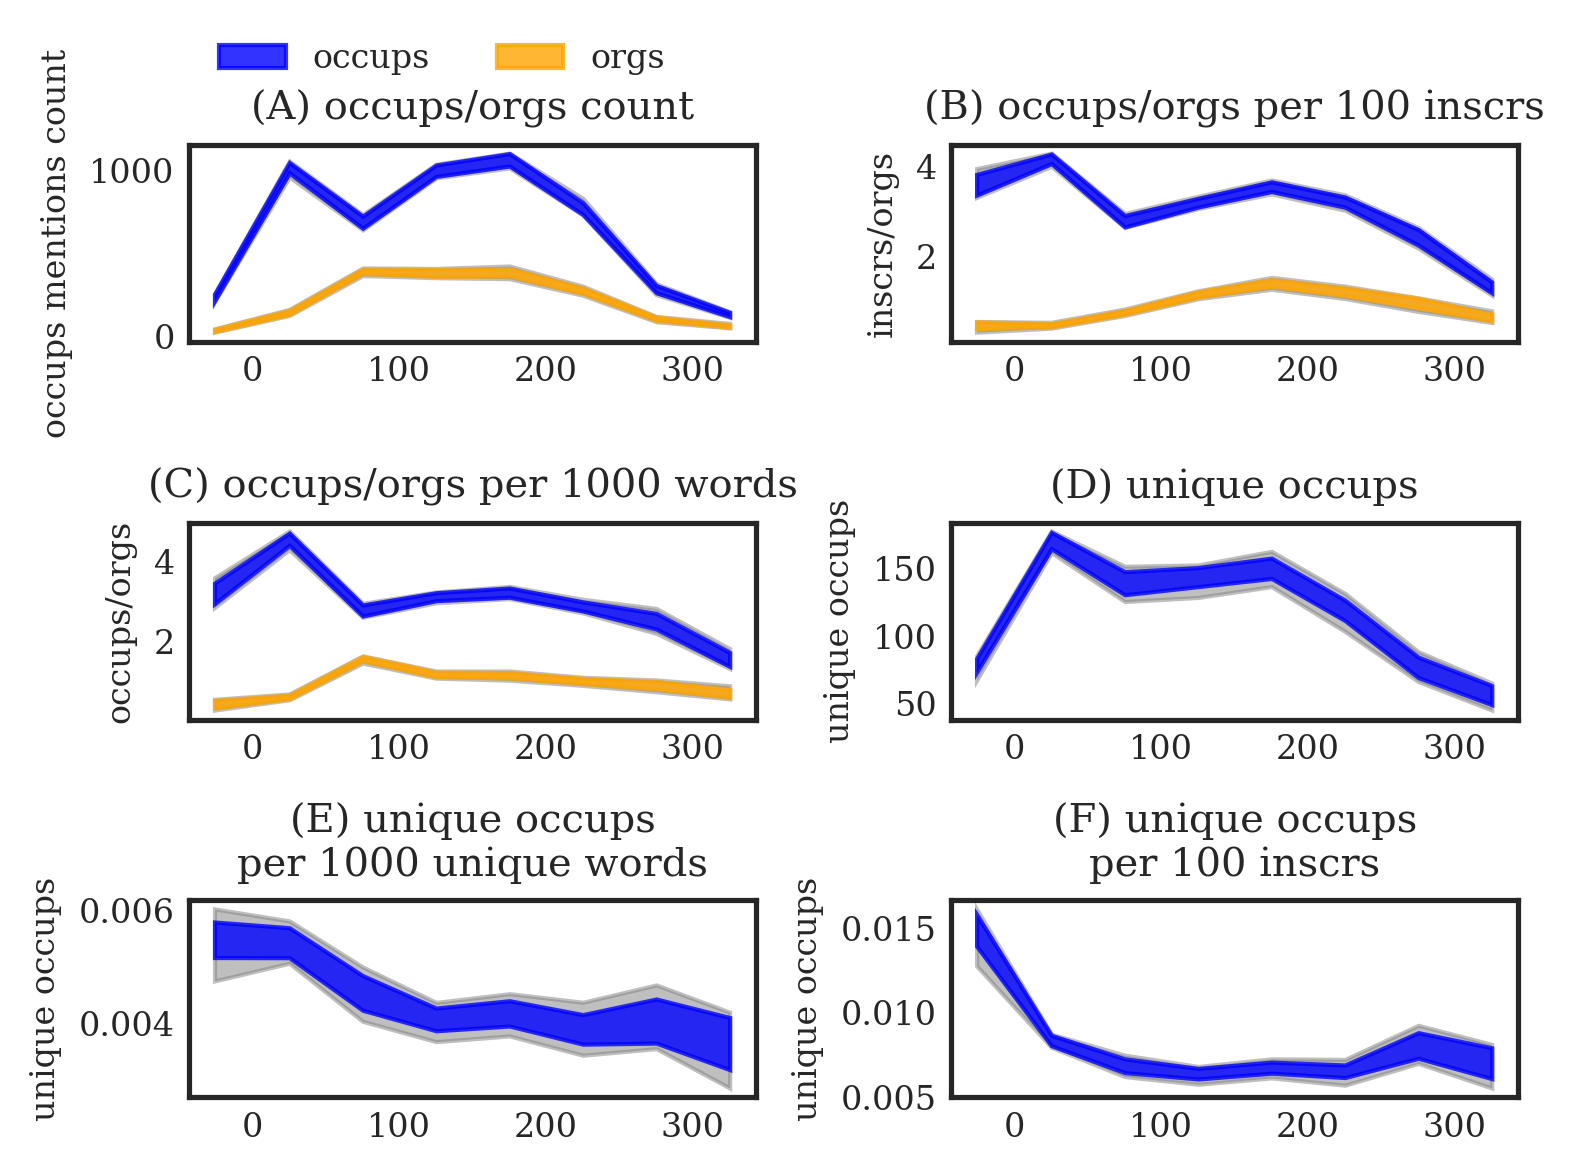

In [185]:
#plt.style.use("seaborn-white")

fig, axs  = plt.subplots(3, 2, figsize=(5.2, 4), tight_layout=True)
n = 0
for sim_data, ax in zip(sim_data_list, axs.ravel()):
        for plot_data, color, label in zip(sim_data[0], ["blue", "orange"], ["occups", "orgs"]):
            tempun.plot_timeblocks_data(plot_data, ax, color, label=label, alpha=0.8)
            n += 1
        ax.set_title(sim_data[1])
        ax.set_ylabel(sim_data[2])
        if sim_data[1] == "(A) occups/orgs count":
            ax.legend(ncol=2, bbox_to_anchor=(0, 1.2), loc="lower left")

In [186]:
s.write_file("SDAM_data/social_diversity/LIRE_occupsorgs_temporal.png", fig)
s.write_file("SDAM_data/social_diversity/LIRE_occupsorgs_temporal.eps", fig)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/LIRE_occupsorgs_temporal.png"


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/LIRE_occupsorgs_temporal.eps"


# Occupations & organizations by periods

In [171]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Julio-Claudians" : {"startdate": -27, "enddate" : 67},
    "Flavians" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 193},
    # or:
    #"5 good emperors" : {"startdate": 97, "enddate": 180},
    #"Commodus" : {"startdate" : 181, "enddate" : 193},
    "Severan dynasty" : {"startdate": 194, "enddate": 235},
    "Crisis of the 3rd\nCentury" : {"startdate" : 236, "enddate" : 284},
    "Diocetian\n& Constantine" : {"startdate" : 285, "enddate" : 337}
    }
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-27, 67), (69, 96), (97, 193), (194, 235), (236, 284), (285, 337)]

In [172]:
# various metrics on the level of timeblocks
def occups_count(timeblock_df):
    return timeblock_df["occups_N"].sum()

def orgs_count(timeblock_df):
    return timeblock_df["organizations_N"].sum()

def occups_per_1K_ins(timeblock_df):
    timeblock_sample = timeblock_df.sample(1000, replace=True)
    occups_N_sum = timeblock_sample["occups_N"].sum()
    return occups_N_sum

def orgs_per_1K_ins(timeblock_df):
    timeblock_sample = timeblock_df.sample(1000, replace=True)
    occups_N_sum = timeblock_sample["organizations_N"].sum()
    return occups_N_sum

In [173]:
%%time

# time consuming, apply carefully
#occups_counts = sim_data_by_function(EDH, 1000, timeblocks_periods, occups_count) 
occups_ins_ratio = tempun.sim_data_by_function(LIREg, 1000, timeblocks_periods, occups_per_1K_ins)
#orgs_counts = sim_data_by_function(EDH, 1000, timeblocks_periods, orgs_count) 
orgs_ins_ratio = tempun.sim_data_by_function(LIREg, 1000, timeblocks_periods, orgs_per_1K_ins)

CPU times: user 23min 43s, sys: 4.21 s, total: 23min 47s
Wall time: 23min 47s


In [174]:
occups_ins_ratio[2]

[((-27, 67), 50),
 ((69, 96), 34),
 ((97, 193), 29),
 ((194, 235), 50),
 ((236, 284), 25),
 ((285, 337), 14)]

In [175]:
def simulations_merged(simulation_data):
    merged_data = []
    for n in range(len(simulation_data[0])): # choose the first simulation to get the length 
        merged_data.append((simulation_data[0][n][0], [sim[n][1] for sim in simulation_data]))
    return merged_data

occups_ratios_merged = simulations_merged(occups_ins_ratio)
orgs_ratios_merged = simulations_merged(orgs_ins_ratio)

In [176]:
occups_ratios_merged = simulations_merged(occups_ins_ratio)
orgs_ratios_merged = simulations_merged(orgs_ins_ratio)

In [177]:
[key for key in periods.keys()]

['Julio-Claudians',
 'Flavians',
 'Nerva-Antonine',
 'Severan dynasty',
 'Crisis of the 3rd\nCentury',
 'Diocetian\n& Constantine']

In [178]:
[abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]

[94, 27, 96, 41, 48, 52]

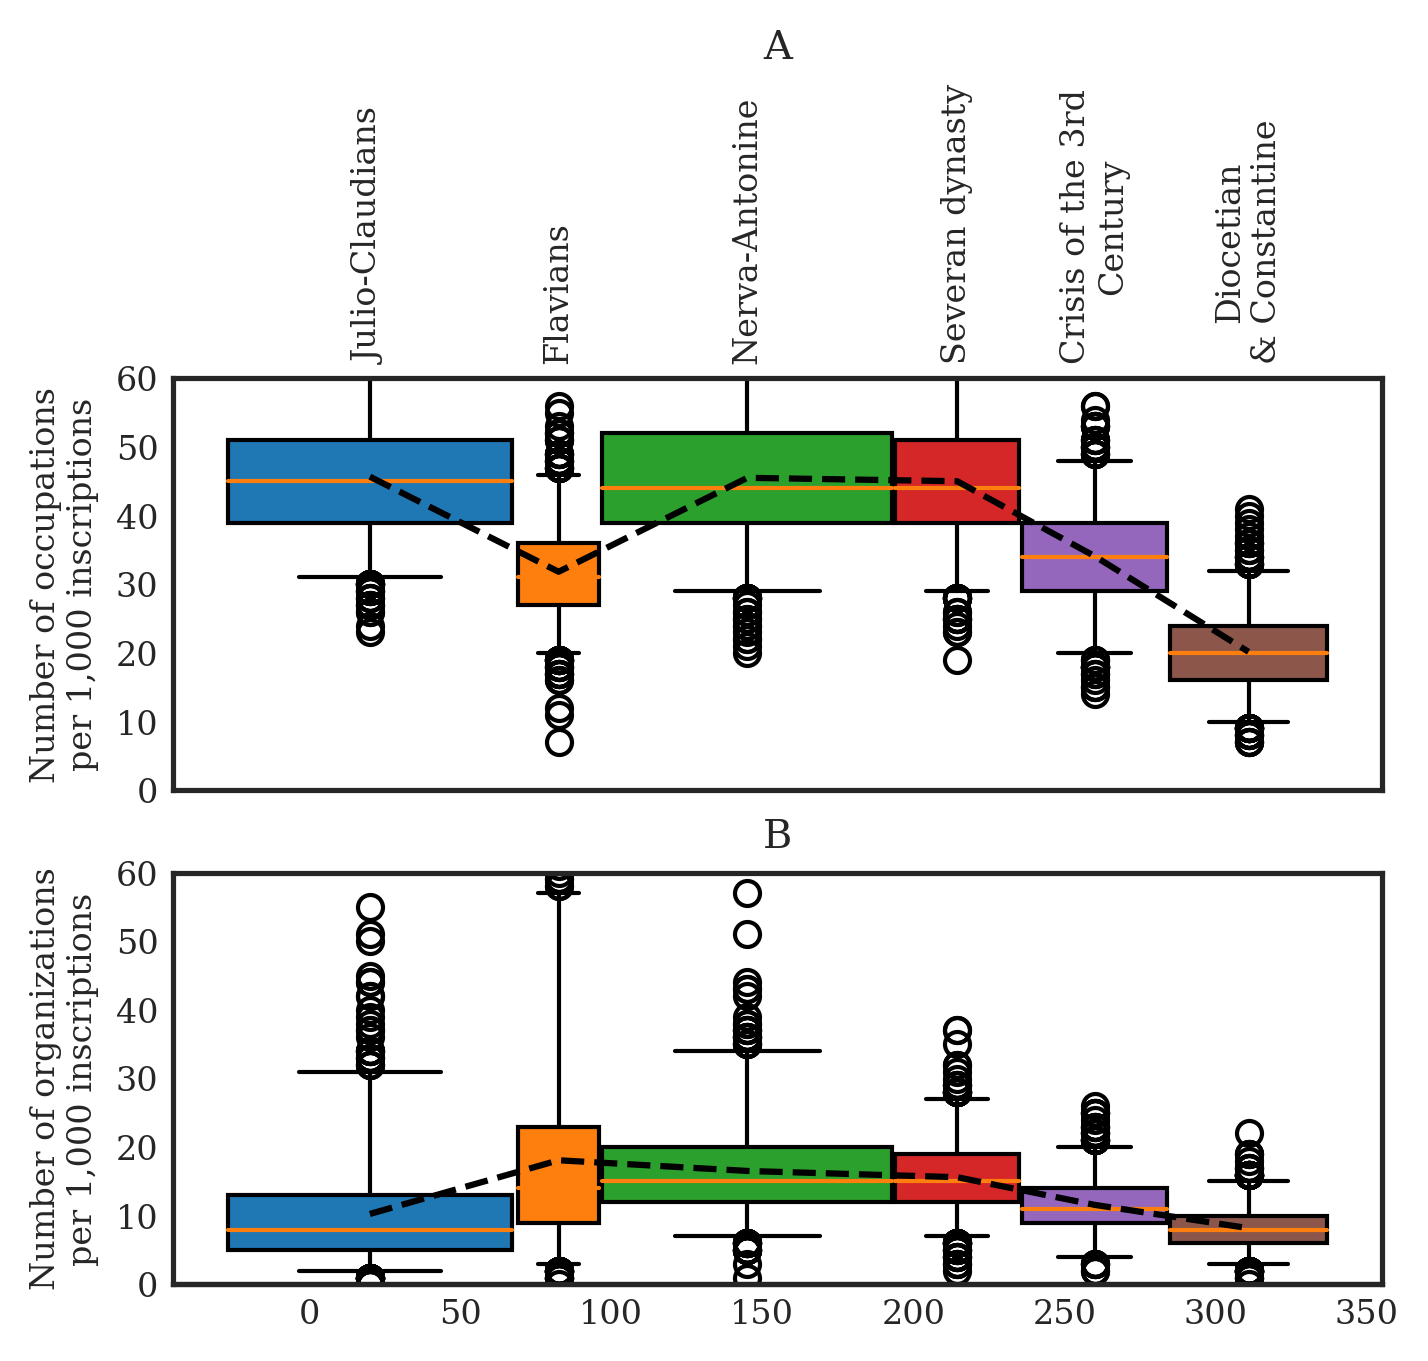

In [187]:
# number of occupations/organizizations per 1,000 randomly sampled inscriptions. The samples are with replacement. Each sample is based on different dating simulation. 


labels=[key for key in periods.keys()]
widths = [abs(tup[0][1] - tup[0][0]) for tup in occups_ratios_merged]
positions = [np.mean(tup[0]) for tup in occups_ratios_merged]


fig, [ax1, ax2] = plt.subplots(2,1, figsize=[5.2,4])

data1 = [tup[1] for tup in occups_ratios_merged]
means1 = [np.mean(tup[1]) for tup in occups_ratios_merged]

bplot1 = ax1.boxplot(data1, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.plot(positions, means1, color="black", linestyle="dashed", zorder=10)


ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.set_ylim(0, 60)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()
#ax1.secondary_xaxis("bottom")
#ax1.set_xlim(-50, 350)



data2 = [tup[1] for tup in orgs_ratios_merged]
means2 = [np.mean(tup[1]) for tup in orgs_ratios_merged]

bplot2 = ax2.boxplot(data2, positions=positions, widths=widths, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.plot(positions, means2, color="black", linestyle="dashed", zorder=10)

ax2.set_title("B")
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")
ax2.set_ylim(0, 60)
ax2.xaxis.set_tick_params(rotation=90)
ax2.xaxis.tick_top()
ax2.set_xticks([])
ax2.secondary_xaxis("bottom")

# fill with colors
colors =tab_colors_list[:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [ ]:
s.write_file("SDAM_data/social_diversity/o")